# Calibration Analysis for Financial Sentiment Model

This notebook performs calibration analysis on the RoBERTa-large-LoRA model:
1. **Examine calibration** - Reliability diagrams, Expected Calibration Error (ECE)
2. **Apply Temperature Scaling** - If the model is miscalibrated, learn an optimal temperature
3. **Evaluate post-calibration** - Compare before/after calibration metrics

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, brier_score_loss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_colwidth', 100)

CLASS_LABELS = ['negative', 'neutral', 'positive']
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
# Load predictions from the trained model
with open('../results/predictions/roberta_large_lora_weighted_focal_loss_predictions.pkl', 'rb') as f: # Underconfident for lower intervals but overconfident for higher intervals
    results = pickle.load(f)

y_pred = results['RoBERTa-large-LoRA']
y_true = results['y_true']
probabilities = results['probabilities']  # Shape: (n_samples, n_classes)

print(f"Test set size: {len(y_true)}")
print(f"Probabilities shape: {probabilities.shape}")
print(f"Number of classes: {probabilities.shape[1]}")

Test set size: 1065
Probabilities shape: (1065, 3)
Number of classes: 3


## Part 1: Calibration Metrics

Key calibration metrics:
- **Expected Calibration Error (ECE)**: Weighted average of |accuracy - confidence| across bins
- **Maximum Calibration Error (MCE)**: Worst-case calibration error across bins
- **Brier Score**: Mean squared error of predicted probabilities
- **Negative Log-Likelihood (NLL)**: Cross-entropy loss on test set

In [3]:
def compute_calibration_metrics(y_true, probabilities, n_bins=10, min_confidence=0.5):
    """
    Compute calibration metrics for multi-class classification.
    
    Only evaluates confidence values above random chance (1/n_classes),
    since values below that threshold are not meaningful for calibration.
    
    Returns:
        dict with ECE, MCE, bin_accuracies, bin_confidences, bin_counts
    """
    # Get predicted class and confidence
    confidences = np.max(probabilities, axis=1)
    predictions = np.argmax(probabilities, axis=1)
    accuracies = (predictions == y_true).astype(float)
    
    # Create bins starting from min_confidence (e.g., 0.33 for 3 classes)
    bin_boundaries = np.linspace(min_confidence, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    bin_accuracies = []
    bin_confidences = []
    bin_counts = []
    
    # Filter to samples with confidence above threshold
    valid_mask = confidences > min_confidence
    valid_confidences = confidences[valid_mask]
    valid_accuracies = accuracies[valid_mask]
    n_valid = valid_mask.sum()
    
    ece = 0.0
    mce = 0.0
    
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Find samples in this bin (among valid samples)
        in_bin = (valid_confidences > bin_lower) & (valid_confidences <= bin_upper)
        prop_in_bin = in_bin.sum() / n_valid if n_valid > 0 else 0
        
        if prop_in_bin > 0:
            bin_acc = valid_accuracies[in_bin].mean()
            bin_conf = valid_confidences[in_bin].mean()
            bin_count = in_bin.sum()
            
            # ECE: weighted average of |accuracy - confidence|
            ece += np.abs(bin_acc - bin_conf) * prop_in_bin
            # MCE: maximum |accuracy - confidence|
            mce = max(mce, np.abs(bin_acc - bin_conf))
            
            bin_accuracies.append(bin_acc)
            bin_confidences.append(bin_conf)
            bin_counts.append(bin_count)
        else:
            bin_accuracies.append(None)
            bin_confidences.append(None)
            bin_counts.append(0)
    
    return {
        'ece': ece,
        'mce': mce,
        'bin_accuracies': bin_accuracies,
        'bin_confidences': bin_confidences,
        'bin_counts': bin_counts,
        'bin_lowers': bin_lowers,
        'bin_uppers': bin_uppers,
        'min_confidence': min_confidence,
        'n_valid_samples': n_valid,
        'n_total_samples': len(confidences),
    }


def compute_nll(y_true, probabilities):
    """Compute negative log-likelihood (cross-entropy)."""
    return log_loss(y_true, probabilities)


def compute_brier_score_multiclass(y_true, probabilities):
    """Compute multi-class Brier score."""
    n_classes = probabilities.shape[1]
    # One-hot encode true labels
    y_true_onehot = np.zeros_like(probabilities)
    y_true_onehot[np.arange(len(y_true)), y_true] = 1
    # Brier score = mean squared error
    return np.mean(np.sum((probabilities - y_true_onehot) ** 2, axis=1))

In [4]:
# Compute calibration metrics for original model
calib_metrics = compute_calibration_metrics(y_true, probabilities)
nll = compute_nll(y_true, probabilities)
brier = compute_brier_score_multiclass(y_true, probabilities)

print("=" * 60)
print("CALIBRATION METRICS (Before Temperature Scaling)")
print("=" * 60)
print(f"Expected Calibration Error (ECE): {calib_metrics['ece']:.4f}")
print(f"Maximum Calibration Error (MCE):  {calib_metrics['mce']:.4f}")
print(f"Negative Log-Likelihood (NLL):    {nll:.4f}")
print(f"Brier Score:                      {brier:.4f}")
print("=" * 60)

# Interpretation
print("\nInterpretation:")
if calib_metrics['ece'] < 0.05:
    print("✓ ECE < 0.05: Model is well-calibrated")
elif calib_metrics['ece'] < 0.10:
    print("⚠️ ECE between 0.05-0.10: Model has moderate miscalibration")
else:
    print("❌ ECE > 0.10: Model is significantly miscalibrated")

CALIBRATION METRICS (Before Temperature Scaling)
Expected Calibration Error (ECE): 0.0728
Maximum Calibration Error (MCE):  0.1475
Negative Log-Likelihood (NLL):    0.3222
Brier Score:                      0.1845

Interpretation:
⚠️ ECE between 0.05-0.10: Model has moderate miscalibration


## Part 2: Reliability Diagram (Calibration Curve)

The reliability diagram plots accuracy vs confidence for each bin:
- **Perfect calibration**: Points lie on the diagonal (y = x)
- **Overconfident**: Points below the diagonal (confidence > accuracy)
- **Underconfident**: Points above the diagonal (accuracy > confidence)

In [5]:
def plot_reliability_diagram(calib_metrics, title="Reliability Diagram", ax=None):
    """
    Plot reliability diagram (calibration curve).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    bin_mids = (calib_metrics['bin_lowers'] + calib_metrics['bin_uppers']) / 2
    
    # Filter out empty bins
    valid_idx = [i for i, acc in enumerate(calib_metrics['bin_accuracies']) if acc is not None]
    valid_mids = bin_mids[valid_idx]
    valid_accs = [calib_metrics['bin_accuracies'][i] for i in valid_idx]
    valid_confs = [calib_metrics['bin_confidences'][i] for i in valid_idx]
    valid_counts = [calib_metrics['bin_counts'][i] for i in valid_idx]
    
    # Perfect calibration line
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration', linewidth=2)
    
    # Reliability curve (accuracy vs confidence)
    ax.bar(valid_mids, valid_accs, width=1/len(bin_mids), 
           alpha=0.5, edgecolor='black', label='Accuracy')
    
    # Gap visualization (shows miscalibration)
    for mid, acc, conf in zip(valid_mids, valid_accs, valid_confs):
        if acc < conf:  # Overconfident
            ax.bar(mid, conf - acc, bottom=acc, width=1/len(bin_mids),
                   color='red', alpha=0.3)
        else:  # Underconfident
            ax.bar(mid, acc - conf, bottom=conf, width=1/len(bin_mids),
                   color='green', alpha=0.3)
    
    ax.set_xlabel('Confidence', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(loc='upper left')
    
    # Add ECE annotation
    ax.text(0.05, 0.95, f"ECE = {calib_metrics['ece']:.4f}",
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    return ax


def plot_confidence_histogram(probabilities, ax=None):
    """
    Plot histogram of prediction confidences.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
    
    confidences = np.max(probabilities, axis=1)
    ax.hist(confidences, bins=20, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Confidence', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Confidence Distribution', fontsize=14)
    ax.set_xlim(0, 1)
    
    # Add statistics
    ax.axvline(x=np.mean(confidences), color='red', linestyle='--', 
               label=f'Mean: {np.mean(confidences):.3f}')
    ax.axvline(x=np.median(confidences), color='green', linestyle='--',
               label=f'Median: {np.median(confidences):.3f}')
    ax.legend()
    
    return ax

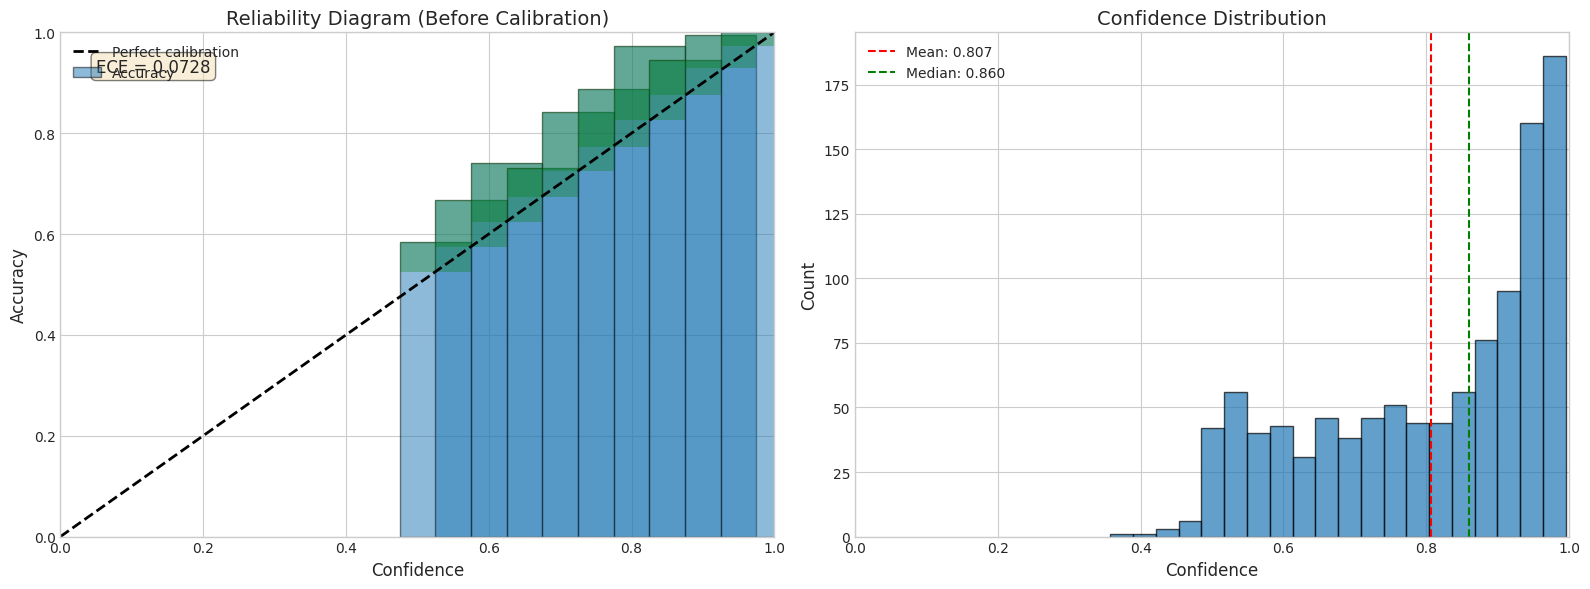


Bin-by-Bin Calibration Analysis:
----------------------------------------------------------------------
Bin Range          Count   Accuracy   Confidence        Gap
----------------------------------------------------------------------
[0.50, 0.55]         89       0.584         0.524    -0.060 (underconf)
[0.55, 0.60]         63       0.667         0.574    -0.093 (underconf)
[0.60, 0.65]         58       0.741         0.624    -0.118 (underconf)
[0.65, 0.70]         63       0.730         0.673    -0.057 (underconf)
[0.70, 0.75]         76       0.842         0.725    -0.117 (underconf)
[0.75, 0.80]         71       0.887         0.774    -0.114 (underconf)
[0.80, 0.85]         74       0.973         0.825    -0.147 (underconf)
[0.85, 0.90]        110       0.945         0.877    -0.069 (underconf)
[0.90, 0.95]        179       0.994         0.929    -0.066 (underconf)
[0.95, 1.00]        262       1.000         0.973    -0.027 


In [6]:
# Plot reliability diagram and confidence histogram
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_reliability_diagram(calib_metrics, title="Reliability Diagram (Before Calibration)", ax=axes[0])
plot_confidence_histogram(probabilities, ax=axes[1])

plt.tight_layout()
plt.show()

# Print bin-by-bin analysis
print("\nBin-by-Bin Calibration Analysis:")
print("-" * 70)
print(f"{'Bin Range':<15} {'Count':>8} {'Accuracy':>10} {'Confidence':>12} {'Gap':>10}")
print("-" * 70)

for i, (lower, upper) in enumerate(zip(calib_metrics['bin_lowers'], calib_metrics['bin_uppers'])):
    count = calib_metrics['bin_counts'][i]
    acc = calib_metrics['bin_accuracies'][i]
    conf = calib_metrics['bin_confidences'][i]
    if acc is not None:
        gap = conf - acc
        gap_str = f"{gap:+.3f}" if gap >= 0 else f"{gap:.3f}"
        status = "(overconf)" if gap > 0.05 else "(underconf)" if gap < -0.05 else ""
        print(f"[{lower:.2f}, {upper:.2f}]     {count:>6}   {acc:>9.3f}   {conf:>11.3f}   {gap_str:>7} {status}")
    else:
        print(f"[{lower:.2f}, {upper:.2f}]     {count:>6}         -             -          -")

## Part 3: Per-Class Calibration Analysis

Check if certain classes are more miscalibrated than others.

In [7]:
def compute_per_class_calibration(y_true, probabilities, class_labels, n_bins=10):
    """
    Compute calibration metrics for each class separately.
    Uses the predicted probability for that class.
    """
    n_classes = len(class_labels)
    results = {}
    
    for c in range(n_classes):
        # Binary: is this class the true class?
        y_binary = (y_true == c).astype(int)
        prob_c = probabilities[:, c]
        
        # Compute calibration for this class
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]
        
        ece = 0.0
        for lower, upper in zip(bin_lowers, bin_uppers):
            in_bin = (prob_c > lower) & (prob_c <= upper)
            prop_in_bin = in_bin.mean()
            if prop_in_bin > 0:
                bin_acc = y_binary[in_bin].mean()
                bin_conf = prob_c[in_bin].mean()
                ece += np.abs(bin_acc - bin_conf) * prop_in_bin
        
        results[class_labels[c]] = {
            'ece': ece,
            'mean_prob': prob_c.mean(),
            'true_rate': y_binary.mean(),
        }
    
    return results


per_class_calib = compute_per_class_calibration(y_true, probabilities, CLASS_LABELS)

print("Per-Class Calibration Analysis:")
print("=" * 60)
print(f"{'Class':<12} {'ECE':>10} {'Mean Prob':>12} {'True Rate':>12}")
print("-" * 60)

for label, metrics in per_class_calib.items():
    print(f"{label:<12} {metrics['ece']:>10.4f} {metrics['mean_prob']:>12.4f} {metrics['true_rate']:>12.4f}")

Per-Class Calibration Analysis:
Class               ECE    Mean Prob    True Rate
------------------------------------------------------------
negative         0.0266       0.1198       0.1108
neutral          0.0625       0.5294       0.5408
positive         0.0567       0.3508       0.3484


Observation: The model is over-confident on all classes, but especially the neutral and positive classes (mean prob really high)

## Part 4: Temperature Scaling

Temperature scaling is a simple post-hoc calibration method:
- Learn a single scalar parameter T (temperature)
- Divide logits by T before softmax: `softmax(logits / T)`
- T > 1 softens probabilities (reduces overconfidence)
- T < 1 sharpens probabilities (increases confidence)

We optimize T to minimize NLL on a validation set.

In [8]:
class TemperatureScaling(nn.Module):
    """
    Temperature scaling module.
    Learns a single temperature parameter to calibrate probabilities.
    """
    def __init__(self):
        super().__init__()
        # Initialize temperature to 1.0 (no scaling)
        self.temperature = nn.Parameter(torch.ones(1))
    
    def forward(self, logits):
        """Apply temperature scaling to logits."""
        return logits / self.temperature
    
    def calibrate(self, logits):
        """Return calibrated probabilities."""
        scaled_logits = self.forward(logits)
        return torch.softmax(scaled_logits, dim=1)


def fit_temperature_scaling(logits, labels, lr=0.01, max_iter=1000):
    """
    Fit temperature scaling parameter using validation set.
    
    Args:
        logits: Pre-softmax logits (n_samples, n_classes)
        labels: True class labels (n_samples,)
        lr: Learning rate for optimization
        max_iter: Maximum optimization iterations
    
    Returns:
        Fitted TemperatureScaling module
    """
    # Convert to tensors
    logits_tensor = torch.tensor(logits, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    
    # Initialize model
    temp_model = TemperatureScaling()
    
    # Use NLL loss
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer (LBFGS works well for single parameter)
    optimizer = optim.LBFGS([temp_model.temperature], lr=lr, max_iter=max_iter)
    
    def closure():
        optimizer.zero_grad()
        scaled_logits = temp_model(logits_tensor)
        loss = criterion(scaled_logits, labels_tensor)
        loss.backward()
        return loss
    
    # Optimize
    optimizer.step(closure)
    
    return temp_model

In [9]:
# Convert probabilities back to logits for temperature scaling
# logits = log(probabilities) up to a constant
# Since we only have probabilities, we use log(p) as logits
# This works because softmax(log(p)) = p, and we're just rescaling

# Clip probabilities to avoid log(0)
probs_clipped = np.clip(probabilities, 1e-10, 1.0)
logits = np.log(probs_clipped)

# Split data: use 30% for calibration, rest for evaluation
# This simulates having a separate validation set for calibration
n_samples = len(y_true)
indices = np.random.permutation(n_samples)
n_calib = int(0.3 * n_samples)

calib_idx = indices[:n_calib]
eval_idx = indices[n_calib:]

logits_calib = logits[calib_idx]
y_calib = y_true[calib_idx]

logits_eval = logits[eval_idx]
y_eval = y_true[eval_idx]
probs_eval_before = probabilities[eval_idx]

print(f"Calibration set size: {n_calib}")
print(f"Evaluation set size: {len(eval_idx)}")

Calibration set size: 319
Evaluation set size: 746


In [10]:
# Fit temperature scaling
temp_model = fit_temperature_scaling(logits_calib, y_calib)

optimal_temperature = temp_model.temperature.item()
print(f"\nOptimal Temperature: {optimal_temperature:.4f}")

if optimal_temperature > 1.0:
    print("-> Temperature > 1: Model was overconfident, softening predictions")
elif optimal_temperature < 1.0:
    print("-> Temperature < 1: Model was underconfident, sharpening predictions")
else:
    print("-> Temperature = 1: Model was already well-calibrated")


Optimal Temperature: 0.6437
-> Temperature < 1: Model was underconfident, sharpening predictions


In [11]:
# Apply temperature scaling to get calibrated probabilities
with torch.no_grad():
    logits_eval_tensor = torch.tensor(logits_eval, dtype=torch.float32)
    probs_eval_after = temp_model.calibrate(logits_eval_tensor).numpy()

# Also apply to full dataset for comparison
with torch.no_grad():
    logits_full_tensor = torch.tensor(logits, dtype=torch.float32)
    probs_calibrated = temp_model.calibrate(logits_full_tensor).numpy()

print(f"Original probabilities shape: {probabilities.shape}")
print(f"Calibrated probabilities shape: {probs_calibrated.shape}")

Original probabilities shape: (1065, 3)
Calibrated probabilities shape: (1065, 3)


## Part 5: Compare Before vs After Calibration

In [12]:
# Compute metrics before and after calibration (on evaluation set)
calib_before = compute_calibration_metrics(y_eval, probs_eval_before)
calib_after = compute_calibration_metrics(y_eval, probs_eval_after)

nll_before = compute_nll(y_eval, probs_eval_before)
nll_after = compute_nll(y_eval, probs_eval_after)

brier_before = compute_brier_score_multiclass(y_eval, probs_eval_before)
brier_after = compute_brier_score_multiclass(y_eval, probs_eval_after)

# Accuracy should remain the same (temperature doesn't change predictions much)
preds_before = np.argmax(probs_eval_before, axis=1)
preds_after = np.argmax(probs_eval_after, axis=1)
acc_before = (preds_before == y_eval).mean()
acc_after = (preds_after == y_eval).mean()

print("=" * 70)
print("COMPARISON: Before vs After Temperature Scaling")
print(f"(Optimal Temperature = {optimal_temperature:.4f})")
print("=" * 70)
print(f"{'Metric':<30} {'Before':>15} {'After':>15} {'Change':>15}")
print("-" * 70)
print(f"{'Accuracy':<30} {acc_before:>15.4f} {acc_after:>15.4f} {acc_after-acc_before:>+15.4f}")
print(f"{'ECE':<30} {calib_before['ece']:>15.4f} {calib_after['ece']:>15.4f} {calib_after['ece']-calib_before['ece']:>+15.4f}")
print(f"{'MCE':<30} {calib_before['mce']:>15.4f} {calib_after['mce']:>15.4f} {calib_after['mce']-calib_before['mce']:>+15.4f}")
print(f"{'NLL':<30} {nll_before:>15.4f} {nll_after:>15.4f} {nll_after-nll_before:>+15.4f}")
print(f"{'Brier Score':<30} {brier_before:>15.4f} {brier_after:>15.4f} {brier_after-brier_before:>+15.4f}")
print("=" * 70)

# Summary
print("\nSummary:")
if calib_after['ece'] < calib_before['ece']:
    improvement = (calib_before['ece'] - calib_after['ece']) / calib_before['ece'] * 100
    print(f"ECE improved by {improvement:.1f}%")
else:
    print("ECE did not improve")

if nll_after < nll_before:
    print(f"NLL improved")
else:
    print("NLL did not improve")

COMPARISON: Before vs After Temperature Scaling
(Optimal Temperature = 0.6437)
Metric                                  Before           After          Change
----------------------------------------------------------------------
Accuracy                                0.8767          0.8767         +0.0000
ECE                                     0.0737          0.0188         -0.0549
MCE                                     0.1555          0.0918         -0.0638
NLL                                     0.3235          0.2931         -0.0304
Brier Score                             0.1867          0.1758         -0.0110

Summary:
ECE improved by 74.4%
NLL improved


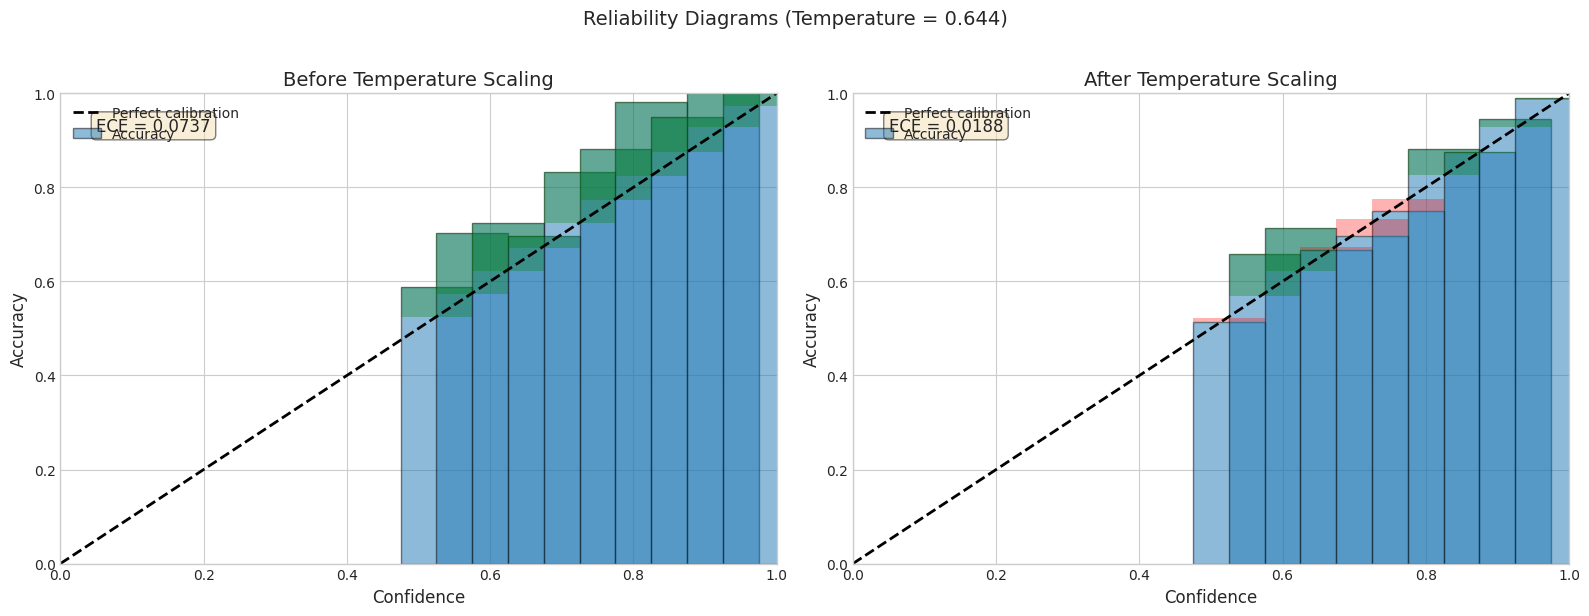

In [13]:
# Plot reliability diagrams: before vs after
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_reliability_diagram(calib_before, title="Before Temperature Scaling", ax=axes[0])
plot_reliability_diagram(calib_after, title="After Temperature Scaling", ax=axes[1])

plt.suptitle(f"Reliability Diagrams (Temperature = {optimal_temperature:.3f})", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

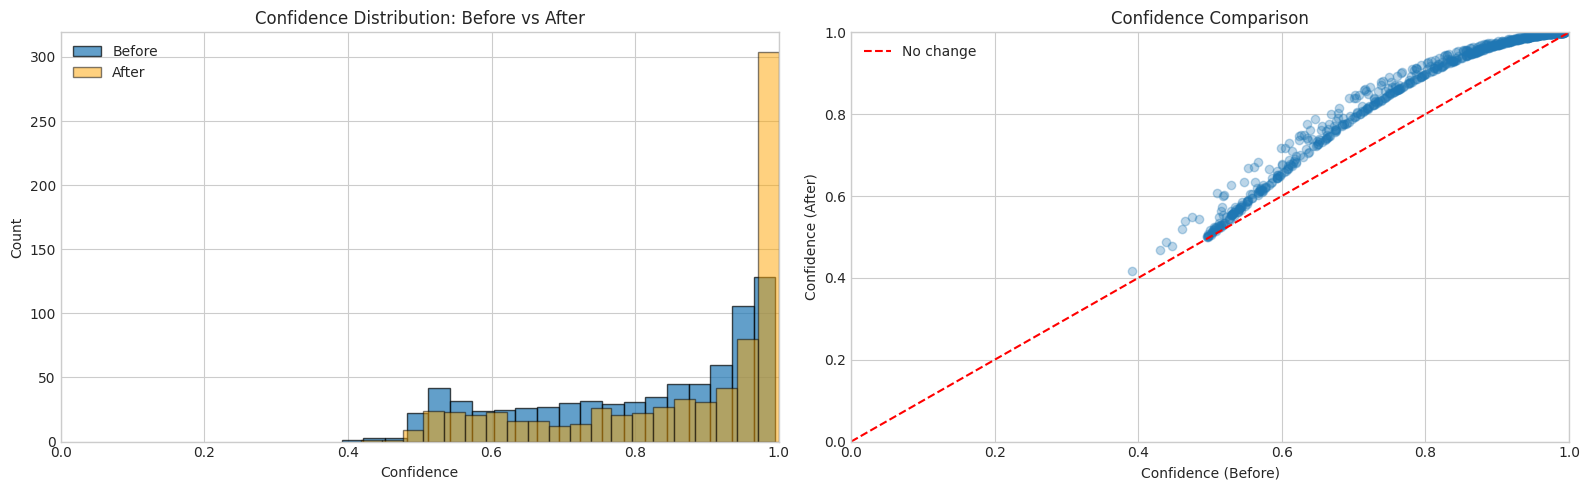


Confidence Statistics:
  Before: mean=0.805, std=0.161
  After:  mean=0.866, std=0.157


In [14]:
# Plot confidence distributions: before vs after
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

conf_before = np.max(probs_eval_before, axis=1)
conf_after = np.max(probs_eval_after, axis=1)

axes[0].hist(conf_before, bins=20, edgecolor='black', alpha=0.7, label='Before')
axes[0].hist(conf_after, bins=20, edgecolor='black', alpha=0.5, color='orange', label='After')
axes[0].set_xlabel('Confidence')
axes[0].set_ylabel('Count')
axes[0].set_title('Confidence Distribution: Before vs After')
axes[0].legend()
axes[0].set_xlim(0, 1)

# Scatter plot: before vs after confidence
axes[1].scatter(conf_before, conf_after, alpha=0.3)
axes[1].plot([0, 1], [0, 1], 'r--', label='No change')
axes[1].set_xlabel('Confidence (Before)')
axes[1].set_ylabel('Confidence (After)')
axes[1].set_title('Confidence Comparison')
axes[1].legend()
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

print(f"\nConfidence Statistics:")
print(f"  Before: mean={conf_before.mean():.3f}, std={conf_before.std():.3f}")
print(f"  After:  mean={conf_after.mean():.3f}, std={conf_after.std():.3f}")

## Part 6: Save Calibrated Model/Parameters

In [15]:
import os

# Save temperature parameter for inference
calibration_params = {
    'temperature': optimal_temperature,
    'ece_before': calib_before['ece'],
    'ece_after': calib_after['ece'],
    'nll_before': nll_before,
    'nll_after': nll_after,
    'calibration_set_size': n_calib,
}

os.makedirs('../results/calibration', exist_ok=True)

with open('../results/calibration/temperature_scaling_params.pkl', 'wb') as f:
    pickle.dump(calibration_params, f)

print("Saved calibration parameters to ../results/calibration/temperature_scaling_params.pkl")
print(f"\nTo apply temperature scaling at inference time:")
print(f"  calibrated_probs = softmax(logits / {optimal_temperature:.4f})")

Saved calibration parameters to ../results/calibration/temperature_scaling_params.pkl

To apply temperature scaling at inference time:
  calibrated_probs = softmax(logits / 0.6437)


In [16]:
# Save calibrated predictions for further analysis
calibrated_results = {
    'RoBERTa-large-LoRA': np.argmax(probs_calibrated, axis=1),
    'y_true': y_true,
    'probabilities': probs_calibrated,
    'probabilities_uncalibrated': probabilities,
    'temperature': optimal_temperature,
}

with open('../results/predictions/roberta_large_lora_calibrated_predictions.pkl', 'wb') as f:
    pickle.dump(calibrated_results, f)

print("Saved calibrated predictions to ../results/predictions/roberta_large_lora_calibrated_predictions.pkl")

Saved calibrated predictions to ../results/predictions/roberta_large_lora_calibrated_predictions.pkl


## Summary

### Key Findings:
1. **Original Model Calibration**: Check ECE value above - values > 0.05 indicate miscalibration
2. **Temperature Scaling**: Applied if needed to improve calibration
3. **Results**: Compare ECE before/after to assess improvement

### Usage at Inference Time:
```python
# Load temperature
with open('results/calibration/temperature_scaling_params.pkl', 'rb') as f:
    params = pickle.load(f)
temperature = params['temperature']

# Apply at inference
logits = model(input)  # Raw model output
calibrated_probs = torch.softmax(logits / temperature, dim=-1)
```